
# Q-GAN

More specifically, we'll use Q-GAN to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import numpy as np

In [2]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.8.0
Default GPU Device: /device:GPU:0


>**Note:** Make sure you have OpenAI Gym cloned. Then run this command 'pip install -e gym/[all]'.

In [5]:
import gym

# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [6]:
env.reset()
rewards, states, actions, dones = [], [], [], []
for _ in range(10):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    states.append(state)
    rewards.append(reward)
    actions.append(action)
    dones.append(done)
    if done:
        states.append(state)
        rewards.append(reward)
        actions.append(action)
        dones.append(done)

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [7]:
print(rewards[-20:])
print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
print('rewards min and max:', np.max(np.array(rewards)), np.min(np.array(rewards)))
print('state size:', np.array(states).shape, 
      'action size: {}'.format((np.max(np.array(actions)) - np.min(np.array(actions)))+1))

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
(10,) (10, 4) (10,) (10,)
float64 float64 int64 bool
actions: 1 0
rewards min and max: 1.0 1.0
state size: (10, 4) action size: 2


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

In [8]:
# Data of the model
def model_input(state_size):
    # Current and next states given
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    
    # Previous and current actions given
    prev_actions = tf.placeholder(tf.int32, [None], name='prev_actions')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    
    # End of episodes/goal/task where nextQs = 0 and Qs=rs
    dones = tf.placeholder(tf.bool, [None], name='dones') # masked

    # Qs = qs+ (gamma * nextQs)
    nextQs = tf.placeholder(tf.float32, [None], name='nextQs') # masked
    nextQs_D = tf.placeholder(tf.float32, [None], name='nextQs_D') # masked
    nextnextQs_G = tf.placeholder(tf.float32, [None], name='nextQs_D') # masked
    
    # returning the given data to the model
    return prev_actions, states, actions, next_states, dones, nextQs, nextQs_D, nextnextQs_G

In [22]:
# Generator: Generating/predicting action and next states
def generator(prev_actions, states, action_size, state_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # Fusing states and actions
        x_fused = tf.concat(axis=1, values=[prev_actions, states])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=(action_size + state_size))
        actions_logits, next_states_logits = tf.split(axis=1, num_or_size_splits=[action_size, state_size], 
                                                      value=logits)
        #predictions = tf.nn.softmax(actions_logits)
        #predictions = tf.sigmoid(next_states_logits)

        # return actions and states logits
        return actions_logits, next_states_logits

In [23]:
def discriminator(prev_actions, states, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fusing states and actions
        x_fused = tf.concat(axis=1, values=[prev_actions, states])
        #print(x_fused.shape)
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        #print(h1.shape)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        #print(h2.shape)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)
        #predictions = tf.nn.softmax(logits)

        # return reward logits/Qs
        return logits

In [40]:
# The model loss for predicted/generated actions
def model_loss(nextQs, prev_actions, states, actions, # model input data for targetQs
               state_size, action_size, hidden_size): # model init for Qs
    # Calculating Qs total rewards
    prev_actions_onehot = tf.one_hot(indices=prev_actions, depth=action_size)
    actions_logits, _ = generator(prev_actions=prev_actions_onehot, states=states, 
                                  hidden_size=hidden_size, state_size=state_size, action_size=action_size)
    
    # Masking actions_logits unmasked
    actions_mask = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    Qs_masked = tf.multiply(actions_logits, actions_mask)
    Qs = tf.reduce_max(Qs_masked, axis=1)
    
    # # Bellman equaion for calculating total rewards using current reward + total future rewards/nextQs
    # qs = tf.sigmoid(Qs) # qt
    # targetQs = qs + (gamma * nextQs)
    # # Calculating the loss: logits/predictions vs labels
    # q_loss = tf.reduce_mean(tf.square(Qs - targetQs))
    q_loss = tf.reduce_mean(tf.square(Qs - nextQs))

    return actions_logits, q_loss

In [41]:
# Outputing the unmasked nextQs for D to be used as the target/label
def model_output(actions, next_states,
                 action_size, hidden_size):
    # Discriminator for nextQs_D
    actions_onehot = tf.one_hot(indices=actions, depth=action_size)
    nextQs_D_unmasked = discriminator(prev_actions=actions_onehot, states=next_states, hidden_size=hidden_size)
    
    # Returning unmasked nextQs_D to masked using dones/ends of episodes
    return nextQs_D_unmasked

In [42]:
# The model loss for the NEW idea G & D
def model_loss2(nextQs_D, prev_actions, states, 
                action_size, hidden_size):
    # Calculating Qs total rewards using Discriminator
    prev_actions_onehot = tf.one_hot(indices=prev_actions, depth=action_size)
    Qs = discriminator(prev_actions=prev_actions_onehot, states=states, hidden_size=hidden_size, reuse=True)
        
    # # Bellman equaion: Qs = rt/qt + nextQs_G/D
    # qs = tf.sigmoid(Qs) # qt
    # targetQs_D = qs + (gamma * nextQs_D)
    # Calculating the loss: logits/predictions vs labels
    #d_loss = tf.reduce_mean(tf.square(Qs - targetQs_D))
    d_loss = tf.reduce_mean(tf.square(Qs - nextQs_D))
    
    # Returning the D loss
    return d_loss

In [43]:
# Calculating the loss of generator based on the generated/predicted states and actions
def model_output2(actions, next_states, 
                  state_size, action_size, hidden_size):
    # Generator for nextnextQs_G
    actions_onehot = tf.one_hot(indices=actions, depth=action_size)
    next_actions_logits, nextnext_states_logits = generator(prev_actions=actions_onehot, states=next_states,
                                                            hidden_size=hidden_size, state_size=state_size, 
                                                            action_size=action_size, reuse=True)
    
    # Discriminator for nextnextQs_G
    nextnextQs_G_unmasked = discriminator(prev_actions=next_actions_logits, states=nextnext_states_logits, 
                                          hidden_size=hidden_size, reuse=True)
        
    # Returning nextnextQs_G_unmasked
    return nextnextQs_G_unmasked

In [44]:
# Calculating the loss of generator based on the generated/predicted states and actions
def model_loss3(nextnextQs_G, prev_actions, states, dones, 
                state_size, action_size, hidden_size):
    # Generator for nextQs_G
    prev_actions_onehot = tf.one_hot(indices=prev_actions, depth=action_size)
    actions_logits, next_states_logits = generator(prev_actions=prev_actions_onehot, states=states,
                                                   hidden_size=hidden_size, state_size=state_size, 
                                                   action_size=action_size, reuse=True)
    
    # Discriminator for nextQs_G
    nextQs_G_unmasked = discriminator(prev_actions=actions_logits, states=next_states_logits, 
                                      hidden_size=hidden_size, reuse=True)
    
    # Masking the unmasked nextQs_G using dones/end of episodes/goal
    dones_mask = tf.reshape(tensor=(1 - tf.cast(dtype=nextQs_G_unmasked.dtype, x=dones)), shape=[-1, 1])
    nextQs_G_masked = tf.multiply(nextQs_G_unmasked, dones_mask)
    nextQs_G = tf.reduce_max(axis=1, input_tensor=nextQs_G_masked)

    # Below is the idea behind this loss
    # # Bellman equaion: Qs = rt/qt + nextQs_G/D
    # qs = tf.sigmoid(Qs) # qt
    # targetQs_G = qs + (gamma * nextQs_G)
    g_loss = tf.reduce_mean(tf.square(nextQs_G - nextnextQs_G))
    
    # Returning g_loss which should impact Generator
    return g_loss

In [45]:
def model_opt(q_loss, g_loss, d_loss, learning_rate):
    """
    Get optimization operations in order
    :param q_loss: Generator loss for action prediction
    :param g_loss: Generator loss for state prediction
    :param d_loss: Discriminator loss for reward prediction
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Used for BN (batchnorm params)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize((q_loss + g_loss), var_list=g_vars) # action prediction
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize((d_loss + g_loss), var_list=d_vars) # reward prediction

    return g_opt, d_opt

In [46]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        ####################################### Model data inputs/outputs #######################################
        # Input of the Model: make the data available inside the framework
        self.prev_actions, self.states, self.actions, self.next_states, self.dones, self.nextQs, self.nextQs_D, self.nextnextQs_G = model_input(
            state_size=state_size)
        
        ######################################## Model losses #####################################################
        # Loss of the Model: action prediction/generation
        self.actions_logits, self.q_loss = model_loss(nextQs=self.nextQs, prev_actions=self.prev_actions, 
                                                      states=self.states, actions=self.actions,
                                                      state_size=state_size, action_size=action_size, 
                                                      hidden_size=hidden_size)

        # Loss of the model: states prediction/generation
        self.nextQs_D_unmasked = model_output(actions=self.actions, next_states=self.next_states,
                                              action_size=action_size, hidden_size=hidden_size)
        self.d_loss = model_loss2(nextQs_D=self.nextQs_D, prev_actions=self.prev_actions, states=self.states,
                                  action_size=action_size, hidden_size=hidden_size)
        
        # Loss of the model: states prediction/generation
        self.nextnextQs_G_unmasked = model_output2(actions=self.actions, next_states=self.next_states,
                                                   state_size=state_size, action_size=action_size, 
                                                   hidden_size=hidden_size)
        self.g_loss = model_loss3(nextnextQs_G=self.nextnextQs_G, dones=self.dones,
                                  prev_actions=self.prev_actions, states=self.states,
                                  state_size=state_size, action_size=action_size, hidden_size=hidden_size)
        
        ######################################## Model updates #####################################################
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(q_loss=self.q_loss,
                                           g_loss=self.g_loss, 
                                           d_loss=self.d_loss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [47]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [48]:
print('state size:', np.array(states).shape[1], 
      'action size: {}'.format((np.max(np.array(actions)) - np.min(np.array(actions)))+1))

state size: 4 action size: 2


In [49]:
# Training params
train_episodes = 2000          # max number of episodes to learn from
max_steps = 2000000000000000   # max steps in an episode

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4                 # number of units for the input state/observation -- simulation
hidden_size = 64               # number of units in each Q-network hidden layer -- simulation
action_size = 2                # number of units for the output actions -- simulation

# Memory parameters
memory_size = 100000           # memory capacity
batch_size = 200               # experience mini-batch size
learning_rate = 0.001          # learning rate for adam

In [50]:
# Reset/init the graph/session
tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

## Populate the memory

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [51]:
# Initialize the simulation
env.reset()

# Take one random step to get the pole and cart moving
prev_action = env.action_space.sample() # At-1
state, _, done, _ = env.step(prev_action) # St, Rt/Et (Epiosde)

# Make a bunch of random actions and store the experiences
for _ in range(batch_size):
    # Make a random action
    action = env.action_space.sample()# At
    next_state, _, done, _ = env.step(action) #St+1

    # End of the episodes which defines the goal of the episode/mission
    if done is True:
        # Add experience to memory
        memory.add((prev_action, state, action, next_state, done))
        
        # Start new episode
        env.reset()
        
        # Take one random step to get the pole and cart moving
        prev_action = env.action_space.sample()
        state, _, done, _ = env.step(prev_action)
    else:
        # Add experience to memory
        memory.add((prev_action, state, action, next_state, done))
        
        # Prepare for the next round
        prev_action = action
        state = next_state

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [39]:
# Now train with experiences
saver = tf.train.Saver()

# Total rewards and losses list for plotting
rewards_list = []
q_loss_list = []
g_loss_list = []
d_loss_list = []

# TF session for training
with tf.Session() as sess:
    
    # Initialize variables
    sess.run(tf.global_variables_initializer())

    # Restore/load the trained model 
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    step = 0
    for ep in range(train_episodes):
        
        # Env/agent steps/batches/minibatches
        total_reward = 0
        q_loss = 0
        g_loss = 0
        d_loss = 0
        t = 0
        while t < max_steps:
            step += 1
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from model
                feed_dict = {model.prev_actions: np.array([prev_action]), 
                             model.states: state.reshape((1, *state.shape))}
                actions_logits = sess.run(model.actions_logits, feed_dict)
                action = np.argmax(actions_logits) # arg with max value/Q is the class of action
            
            # Take action, get new state and reward
            next_state, _, done, _ = env.step(action)
    
            # Cumulative reward
            #total_reward += reward
            total_reward += 1 # done=False
            
            # Episode/epoch training is done/failed!
            if done is True:
                # the episode ends so no next state
                #next_state = np.zeros(state.shape)
                t = max_steps
                
                print('-------------------------------------------------------------------------------')
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Training q_loss: {:.4f}'.format(q_loss),
                      'Training g_loss: {:.4f}'.format(g_loss),
                      'Training d_loss: {:.4f}'.format(d_loss),
                      'Explore P: {:.4f}'.format(explore_p))
                print('-------------------------------------------------------------------------------')
                
                # total rewards and losses for plotting
                rewards_list.append((ep, total_reward))
                q_loss_list.append((ep, q_loss))
                g_loss_list.append((ep, g_loss))
                d_loss_list.append((ep, d_loss))
                
                # Add experience to memory
                memory.add((prev_action, state, action, next_state, done))
                
                # Start new episode
                env.reset()
                
                # Take one random step to get the pole and cart moving
                prev_action = env.action_space.sample()
                state, _, done, _ = env.step(prev_action)

            else:
                # Add experience to memory
                memory.add((prev_action, state, action, next_state, done))
                
                # One step forward: At-1=At and St=St+1
                prev_action = action
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            prev_actions = np.array([each[0] for each in batch])
            states = np.array([each[1] for each in batch])
            actions = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            dones = np.array([each[4] for each in batch])
            
            # Calculating nextQs and setting them to 0 for states where episode ends/fails
            feed_dict={model.prev_actions: actions, 
                       model.states: next_states}
            next_actions_logits = sess.run(model.actions_logits, feed_dict)
            nextQs_unmasked = next_actions_logits # for naming
            
            # Calculating nextQs for Discriminator using D(At, St+1)= Qt+1/nextQs_D/nextQs
            # Calculating nextQs for Discriminator using D(~At, ~St+1)= ~Qt+1/nextQs_G/nextQs2
            feed_dict={model.prev_actions: prev_actions, model.states: states,
                       model.actions: actions, model.next_states: next_states}
            nextQs_D_unmasked, nextnextQs_G_unmasked = sess.run([model.nextQs_D_unmasked,
                                                                 model.nextnextQs_G_unmasked], feed_dict)
            
            # Masking for the end of episodes/ goals
            #dones_mask = (1 - dones.astype(nextQs_D_unmasked[0].dtype)).reshape(-1, 1)
            dones_mask = (1 - dones.astype(nextQs_unmasked.dtype)).reshape(-1, 1) 
            nextQs_masked = np.multiply(nextQs_unmasked, dones_mask)
            nextQs_D_masked = np.multiply(nextQs_D_unmasked[0], dones_mask)
            nextnextQs_G_masked = np.multiply(nextnextQs_G_unmasked[0], dones_mask)
            nextQs = np.max(nextQs_masked, axis=1)
            nextQs_D = np.max(nextQs_D_masked, axis=1)
            nextnextQs_G = np.max(nextnextQs_G_masked, axis=1)
            
            # Calculating nextQs for Discriminator using D(At-1, St)= Qt: NOT this one
            # NextQs/Qt+1 are given both:
            feed_dict = {model.prev_actions: prev_actions, 
                         model.states: states, 
                         model.actions: actions, 
                         model.next_states: next_states, 
                         model.dones: dones,
                         model.nextQs: nextQs,
                         model.nextQs_D: nextQs_D,
                         model.nextnextQs_G: nextnextQs_G}
            q_loss, g_loss, d_loss, _, _ = sess.run([model.q_loss,
                                                     model.g_loss,
                                                     model.d_loss,
                                                     model.g_opt,
                                                     model.d_opt], feed_dict)
                        
    # Save the trained model
    saver.save(sess, 'checkpoints/model.ckpt')

-------------------------------------------------------------------------------
Episode: 0 Total reward: 18 Training q_loss: 0.0450 Training g_loss: 0.0062 Training d_loss: 0.0085 Explore P: 0.9982
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1 Total reward: 8 Training q_loss: 0.0845 Training g_loss: 0.0011 Training d_loss: 0.0049 Explore P: 0.9974
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2 Total reward: 23 Training q_loss: 0.2735 Training g_loss: 0.0003 Training d_loss: 0.0021 Explore P: 0.9952
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3 Total reward: 16 Training q_loss: 0.3611 Training g_loss: 0.0003 Training d_

-------------------------------------------------------------------------------
Episode: 31 Total reward: 8 Training q_loss: 383.4308 Training g_loss: 2.4127 Training d_loss: 0.2112 Explore P: 0.9423
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 32 Total reward: 16 Training q_loss: 406.2784 Training g_loss: 1.0138 Training d_loss: 0.1343 Explore P: 0.9409
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 33 Total reward: 23 Training q_loss: 311.3911 Training g_loss: 0.4633 Training d_loss: 0.2019 Explore P: 0.9387
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 34 Total reward: 45 Training q_loss: 309.5111 Training g_loss: 0.2546

-------------------------------------------------------------------------------
Episode: 62 Total reward: 10 Training q_loss: 288.1628 Training g_loss: 1.0138 Training d_loss: 0.0312 Explore P: 0.8720
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 63 Total reward: 15 Training q_loss: 279.8689 Training g_loss: 0.2245 Training d_loss: 0.0239 Explore P: 0.8707
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 64 Total reward: 10 Training q_loss: 268.9035 Training g_loss: 0.2657 Training d_loss: 0.0239 Explore P: 0.8698
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 65 Total reward: 22 Training q_loss: 258.9249 Training g_loss: 0.203

-------------------------------------------------------------------------------
Episode: 92 Total reward: 14 Training q_loss: 1484.9404 Training g_loss: 25.7706 Training d_loss: 0.4179 Explore P: 0.8191
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 93 Total reward: 73 Training q_loss: 2570.0066 Training g_loss: 12.9092 Training d_loss: 0.6394 Explore P: 0.8132
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 94 Total reward: 17 Training q_loss: 3012.7644 Training g_loss: 3.2330 Training d_loss: 0.8495 Explore P: 0.8118
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 95 Total reward: 19 Training q_loss: 3155.6594 Training g_loss:

-------------------------------------------------------------------------------
Episode: 121 Total reward: 23 Training q_loss: 1347.2589 Training g_loss: 13.1362 Training d_loss: 0.1087 Explore P: 0.7785
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 122 Total reward: 17 Training q_loss: 1395.5420 Training g_loss: 0.7724 Training d_loss: 0.7210 Explore P: 0.7772
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 123 Total reward: 42 Training q_loss: 1450.7036 Training g_loss: 11.8236 Training d_loss: 0.1621 Explore P: 0.7740
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 124 Total reward: 14 Training q_loss: 1530.4181 Training g_l

-------------------------------------------------------------------------------
Episode: 151 Total reward: 12 Training q_loss: 2008.3726 Training g_loss: 1.3340 Training d_loss: 0.2712 Explore P: 0.7403
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 152 Total reward: 31 Training q_loss: 2174.6675 Training g_loss: 0.5953 Training d_loss: 0.2064 Explore P: 0.7380
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 153 Total reward: 9 Training q_loss: 2127.1621 Training g_loss: 0.4537 Training d_loss: 0.1914 Explore P: 0.7373
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 154 Total reward: 12 Training q_loss: 2155.3647 Training g_loss

-------------------------------------------------------------------------------
Episode: 180 Total reward: 55 Training q_loss: 1271.0411 Training g_loss: 0.5472 Training d_loss: 0.2755 Explore P: 0.7022
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 181 Total reward: 12 Training q_loss: 1253.7820 Training g_loss: 0.2525 Training d_loss: 0.0718 Explore P: 0.7014
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 182 Total reward: 13 Training q_loss: 1271.0970 Training g_loss: 0.4177 Training d_loss: 0.1020 Explore P: 0.7005
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 183 Total reward: 9 Training q_loss: 1309.6031 Training g_loss

-------------------------------------------------------------------------------
Episode: 210 Total reward: 38 Training q_loss: 1277.0068 Training g_loss: 2.3697 Training d_loss: 0.1058 Explore P: 0.6668
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 211 Total reward: 17 Training q_loss: 1313.0242 Training g_loss: 0.1525 Training d_loss: 0.0653 Explore P: 0.6656
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 212 Total reward: 8 Training q_loss: 1333.1829 Training g_loss: 0.2588 Training d_loss: 0.1012 Explore P: 0.6651
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 213 Total reward: 10 Training q_loss: 1433.8545 Training g_loss

-------------------------------------------------------------------------------
Episode: 240 Total reward: 38 Training q_loss: 2805.5242 Training g_loss: 0.6431 Training d_loss: 0.1585 Explore P: 0.6360
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 241 Total reward: 19 Training q_loss: 2373.9741 Training g_loss: 1.4421 Training d_loss: 0.1525 Explore P: 0.6348
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 242 Total reward: 16 Training q_loss: 2162.2800 Training g_loss: 3.7951 Training d_loss: 1.2561 Explore P: 0.6338
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 243 Total reward: 28 Training q_loss: 1853.7355 Training g_los

-------------------------------------------------------------------------------
Episode: 270 Total reward: 32 Training q_loss: 1604.4034 Training g_loss: 41.4955 Training d_loss: 0.0452 Explore P: 0.6091
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 271 Total reward: 19 Training q_loss: 1701.7251 Training g_loss: 19.9297 Training d_loss: 0.1393 Explore P: 0.6079
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 272 Total reward: 12 Training q_loss: 1945.7694 Training g_loss: 17.4938 Training d_loss: 0.0826 Explore P: 0.6072
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 273 Total reward: 8 Training q_loss: 2363.8506 Training g_l

-------------------------------------------------------------------------------
Episode: 300 Total reward: 14 Training q_loss: 2171.5576 Training g_loss: 0.3664 Training d_loss: 0.1044 Explore P: 0.5808
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 301 Total reward: 17 Training q_loss: 2394.1096 Training g_loss: 19.7367 Training d_loss: 0.1215 Explore P: 0.5798
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 302 Total reward: 31 Training q_loss: 2770.7246 Training g_loss: 9.0232 Training d_loss: 0.5177 Explore P: 0.5780
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 303 Total reward: 19 Training q_loss: 3033.8530 Training g_lo

-------------------------------------------------------------------------------
Episode: 329 Total reward: 10 Training q_loss: 1540.4937 Training g_loss: 0.3738 Training d_loss: 0.0833 Explore P: 0.5552
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 330 Total reward: 11 Training q_loss: 1663.3818 Training g_loss: 0.7853 Training d_loss: 0.2405 Explore P: 0.5546
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 331 Total reward: 11 Training q_loss: 1635.7679 Training g_loss: 2.8157 Training d_loss: 0.0873 Explore P: 0.5540
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 332 Total reward: 14 Training q_loss: 1674.8087 Training g_los

-------------------------------------------------------------------------------
Episode: 358 Total reward: 16 Training q_loss: 2557.2234 Training g_loss: 1.3012 Training d_loss: 0.2876 Explore P: 0.5329
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 359 Total reward: 24 Training q_loss: 2498.2107 Training g_loss: 0.8555 Training d_loss: 0.1922 Explore P: 0.5316
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 360 Total reward: 10 Training q_loss: 2531.7000 Training g_loss: 2.0693 Training d_loss: 0.3264 Explore P: 0.5311
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 361 Total reward: 9 Training q_loss: 2498.0259 Training g_loss

Episode: 387 Total reward: 16 Training q_loss: 3252.6543 Training g_loss: 6.7862 Training d_loss: 0.9550 Explore P: 0.5115
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 388 Total reward: 27 Training q_loss: 3215.6431 Training g_loss: 13.2737 Training d_loss: 1.6108 Explore P: 0.5101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 389 Total reward: 13 Training q_loss: 2509.7458 Training g_loss: 2.4541 Training d_loss: 0.1698 Explore P: 0.5094
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 390 Total reward: 10 Training q_loss: 2229.7898 Training g_loss: 2.6545 Training d_loss: 0.1344 Explore P: 0.5089
---------------------------

-------------------------------------------------------------------------------
Episode: 416 Total reward: 16 Training q_loss: 45492.8945 Training g_loss: 21508.2734 Training d_loss: 48.9835 Explore P: 0.4887
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 417 Total reward: 12 Training q_loss: 44013.4141 Training g_loss: 3098.4229 Training d_loss: 353.3318 Explore P: 0.4881
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 418 Total reward: 11 Training q_loss: 43488.4844 Training g_loss: 4338.7407 Training d_loss: 58.9903 Explore P: 0.4876
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 419 Total reward: 10 Training q_loss: 42923.6

-------------------------------------------------------------------------------
Episode: 445 Total reward: 12 Training q_loss: 41991.9336 Training g_loss: 106.5627 Training d_loss: 41.4350 Explore P: 0.4716
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 446 Total reward: 10 Training q_loss: 45767.5000 Training g_loss: 922.9677 Training d_loss: 26.6929 Explore P: 0.4712
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 447 Total reward: 23 Training q_loss: 53966.9609 Training g_loss: 526.4314 Training d_loss: 35.3075 Explore P: 0.4701
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 448 Total reward: 15 Training q_loss: 57109.6055 T

-------------------------------------------------------------------------------
Episode: 474 Total reward: 19 Training q_loss: 363547.5625 Training g_loss: 62.9480 Training d_loss: 926.8656 Explore P: 0.4533
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 475 Total reward: 20 Training q_loss: 371183.8750 Training g_loss: 86.4602 Training d_loss: 996.7890 Explore P: 0.4524
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 476 Total reward: 15 Training q_loss: 365169.8438 Training g_loss: 281.1700 Training d_loss: 1411.4928 Explore P: 0.4517
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 477 Total reward: 10 Training q_loss: 365992.

-------------------------------------------------------------------------------
Episode: 504 Total reward: 15 Training q_loss: 380824.8125 Training g_loss: 2152.5547 Training d_loss: 581.8853 Explore P: 0.4342
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 505 Total reward: 15 Training q_loss: 366434.3750 Training g_loss: 95.3158 Training d_loss: 3094.9827 Explore P: 0.4336
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 506 Total reward: 10 Training q_loss: 356403.2500 Training g_loss: 141.3835 Training d_loss: 1459.8916 Explore P: 0.4332
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 507 Total reward: 11 Training q_loss: 3780

-------------------------------------------------------------------------------
Episode: 533 Total reward: 11 Training q_loss: 373556.3125 Training g_loss: 449.8069 Training d_loss: 420.8912 Explore P: 0.4174
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 534 Total reward: 10 Training q_loss: 362279.3125 Training g_loss: 453.1803 Training d_loss: 1926.8073 Explore P: 0.4170
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 535 Total reward: 12 Training q_loss: 373786.4375 Training g_loss: 197.9916 Training d_loss: 477.9223 Explore P: 0.4165
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 536 Total reward: 12 Training q_loss: 37172

-------------------------------------------------------------------------------
Episode: 562 Total reward: 9 Training q_loss: 335691.3125 Training g_loss: 99.9799 Training d_loss: 424.9955 Explore P: 0.4030
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 563 Total reward: 20 Training q_loss: 342370.1875 Training g_loss: 294.6552 Training d_loss: 1199.4951 Explore P: 0.4022
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 564 Total reward: 7 Training q_loss: 353283.8125 Training g_loss: 415.8795 Training d_loss: 1255.5554 Explore P: 0.4019
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 565 Total reward: 10 Training q_loss: 359074.

-------------------------------------------------------------------------------
Episode: 592 Total reward: 8 Training q_loss: 332821.8750 Training g_loss: 177.5641 Training d_loss: 628.9415 Explore P: 0.3884
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 593 Total reward: 13 Training q_loss: 337796.8750 Training g_loss: 515.9008 Training d_loss: 380.3670 Explore P: 0.3879
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 594 Total reward: 14 Training q_loss: 328989.4375 Training g_loss: 1145.8402 Training d_loss: 348.6035 Explore P: 0.3874
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 595 Total reward: 12 Training q_loss: 335980

-------------------------------------------------------------------------------
Episode: 621 Total reward: 15 Training q_loss: 334078.3125 Training g_loss: 1979.0327 Training d_loss: 293.6737 Explore P: 0.3757
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 622 Total reward: 19 Training q_loss: 320006.7812 Training g_loss: 37.1211 Training d_loss: 230.6644 Explore P: 0.3750
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 623 Total reward: 13 Training q_loss: 324603.8438 Training g_loss: 86.5160 Training d_loss: 247.1393 Explore P: 0.3746
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 624 Total reward: 9 Training q_loss: 333495.3

-------------------------------------------------------------------------------
Episode: 650 Total reward: 11 Training q_loss: 281266.7812 Training g_loss: 4910.8564 Training d_loss: 209.7384 Explore P: 0.3628
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 651 Total reward: 15 Training q_loss: 294508.4375 Training g_loss: 223.9868 Training d_loss: 517.7230 Explore P: 0.3622
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 652 Total reward: 10 Training q_loss: 278229.0938 Training g_loss: 2326.7297 Training d_loss: 122.6028 Explore P: 0.3619
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 653 Total reward: 14 Training q_loss: 2972

-------------------------------------------------------------------------------
Episode: 679 Total reward: 27 Training q_loss: 318042.8438 Training g_loss: 97.8013 Training d_loss: 305.2295 Explore P: 0.3494
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 680 Total reward: 7 Training q_loss: 322903.4062 Training g_loss: 67.9744 Training d_loss: 1078.4832 Explore P: 0.3491
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 681 Total reward: 10 Training q_loss: 317764.1250 Training g_loss: 87.3328 Training d_loss: 184.9324 Explore P: 0.3488
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 682 Total reward: 10 Training q_loss: 322962.93

-------------------------------------------------------------------------------
Episode: 709 Total reward: 14 Training q_loss: 140666.7188 Training g_loss: 1534.5306 Training d_loss: 54.7778 Explore P: 0.3370
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 710 Total reward: 11 Training q_loss: 146107.6250 Training g_loss: 4619.4004 Training d_loss: 420.1617 Explore P: 0.3367
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 711 Total reward: 9 Training q_loss: 147175.2344 Training g_loss: 4546.2368 Training d_loss: 674.1947 Explore P: 0.3364
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 712 Total reward: 10 Training q_loss: 14900

-------------------------------------------------------------------------------
Episode: 738 Total reward: 15 Training q_loss: 161216.9375 Training g_loss: 5464.4546 Training d_loss: 43.7986 Explore P: 0.3266
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 739 Total reward: 11 Training q_loss: 154834.4062 Training g_loss: 4136.4067 Training d_loss: 121.9619 Explore P: 0.3262
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 740 Total reward: 9 Training q_loss: 153877.9531 Training g_loss: 23721.7246 Training d_loss: 282.9969 Explore P: 0.3259
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 741 Total reward: 13 Training q_loss: 1575

-------------------------------------------------------------------------------
Episode: 768 Total reward: 11 Training q_loss: 157256.6719 Training g_loss: 947.5834 Training d_loss: 56.8952 Explore P: 0.3163
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 769 Total reward: 13 Training q_loss: 161098.5156 Training g_loss: 1721.4587 Training d_loss: 60.4872 Explore P: 0.3159
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 770 Total reward: 11 Training q_loss: 164171.0938 Training g_loss: 2615.3262 Training d_loss: 49.0127 Explore P: 0.3156
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 771 Total reward: 9 Training q_loss: 161264.3

-------------------------------------------------------------------------------
Episode: 798 Total reward: 10 Training q_loss: 161608.7031 Training g_loss: 8571.4180 Training d_loss: 158.0731 Explore P: 0.3068
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 799 Total reward: 14 Training q_loss: 166155.9531 Training g_loss: 1165.8174 Training d_loss: 26.4498 Explore P: 0.3063
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 800 Total reward: 8 Training q_loss: 169575.7344 Training g_loss: 1428.6622 Training d_loss: 56.0760 Explore P: 0.3061
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 801 Total reward: 9 Training q_loss: 161280.

-------------------------------------------------------------------------------
Episode: 828 Total reward: 10 Training q_loss: 176047.2969 Training g_loss: 3860.2678 Training d_loss: 34.6050 Explore P: 0.2967
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 829 Total reward: 10 Training q_loss: 173781.6875 Training g_loss: 584.0167 Training d_loss: 234.3496 Explore P: 0.2964
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 830 Total reward: 13 Training q_loss: 174734.8438 Training g_loss: 3017.9502 Training d_loss: 22.7187 Explore P: 0.2960
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 831 Total reward: 13 Training q_loss: 179594

-------------------------------------------------------------------------------
Episode: 858 Total reward: 10 Training q_loss: 182701.2344 Training g_loss: 1711.7416 Training d_loss: 83.1750 Explore P: 0.2869
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 859 Total reward: 10 Training q_loss: 182207.2969 Training g_loss: 1994.9100 Training d_loss: 320.3999 Explore P: 0.2867
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 860 Total reward: 11 Training q_loss: 182094.8594 Training g_loss: 1172.1244 Training d_loss: 70.5654 Explore P: 0.2864
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 861 Total reward: 9 Training q_loss: 181330

-------------------------------------------------------------------------------
Episode: 888 Total reward: 13 Training q_loss: 159320.5938 Training g_loss: 5268.7124 Training d_loss: 47.5918 Explore P: 0.2772
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 889 Total reward: 18 Training q_loss: 156459.5469 Training g_loss: 2834.4482 Training d_loss: 33.7345 Explore P: 0.2767
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 890 Total reward: 8 Training q_loss: 155520.9062 Training g_loss: 6754.3823 Training d_loss: 35.5767 Explore P: 0.2765
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 891 Total reward: 13 Training q_loss: 150923.

-------------------------------------------------------------------------------
Episode: 917 Total reward: 8 Training q_loss: 301743.2188 Training g_loss: 12069.0625 Training d_loss: 621.6720 Explore P: 0.2686
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 918 Total reward: 11 Training q_loss: 299579.6250 Training g_loss: 2515.5383 Training d_loss: 168.1347 Explore P: 0.2683
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 919 Total reward: 11 Training q_loss: 297115.6875 Training g_loss: 198.0349 Training d_loss: 192.3730 Explore P: 0.2680
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 920 Total reward: 14 Training q_loss: 2856

-------------------------------------------------------------------------------
Episode: 946 Total reward: 8 Training q_loss: 296031.8125 Training g_loss: 35.9930 Training d_loss: 149.6692 Explore P: 0.2609
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 947 Total reward: 8 Training q_loss: 291524.7500 Training g_loss: 6.7763 Training d_loss: 1052.4471 Explore P: 0.2607
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 948 Total reward: 11 Training q_loss: 288607.0625 Training g_loss: 451.3873 Training d_loss: 157.0020 Explore P: 0.2604
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 949 Total reward: 12 Training q_loss: 289526.218

-------------------------------------------------------------------------------
Episode: 976 Total reward: 11 Training q_loss: 275411.4688 Training g_loss: 25.5367 Training d_loss: 98.1258 Explore P: 0.2528
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 977 Total reward: 16 Training q_loss: 270624.3438 Training g_loss: 511.6542 Training d_loss: 114.5549 Explore P: 0.2524
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 978 Total reward: 12 Training q_loss: 263070.2812 Training g_loss: 337.3520 Training d_loss: 388.3923 Explore P: 0.2521
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 979 Total reward: 9 Training q_loss: 268297.96

-------------------------------------------------------------------------------
Episode: 1005 Total reward: 8 Training q_loss: 231710.9844 Training g_loss: 13223.4521 Training d_loss: 89.1877 Explore P: 0.2455
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1006 Total reward: 14 Training q_loss: 232886.7188 Training g_loss: 3242.4600 Training d_loss: 73.3190 Explore P: 0.2451
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1007 Total reward: 8 Training q_loss: 232146.6250 Training g_loss: 892.1934 Training d_loss: 36.9799 Explore P: 0.2450
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1008 Total reward: 11 Training q_loss: 2191

-------------------------------------------------------------------------------
Episode: 1035 Total reward: 11 Training q_loss: 214851.5156 Training g_loss: 257.2692 Training d_loss: 73.1489 Explore P: 0.2380
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1036 Total reward: 9 Training q_loss: 225656.6406 Training g_loss: 176.4591 Training d_loss: 134.3879 Explore P: 0.2378
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1037 Total reward: 12 Training q_loss: 218674.7031 Training g_loss: 4610.3564 Training d_loss: 71.8604 Explore P: 0.2375
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1038 Total reward: 8 Training q_loss: 21878

-------------------------------------------------------------------------------
Episode: 1065 Total reward: 12 Training q_loss: 214481.5625 Training g_loss: 223.7543 Training d_loss: 29.5385 Explore P: 0.2302
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1066 Total reward: 8 Training q_loss: 209005.2031 Training g_loss: 1215.5989 Training d_loss: 105.7185 Explore P: 0.2300
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1067 Total reward: 11 Training q_loss: 208070.8594 Training g_loss: 2247.1670 Training d_loss: 168.8971 Explore P: 0.2298
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1068 Total reward: 7 Training q_loss: 226

-------------------------------------------------------------------------------
Episode: 1095 Total reward: 21 Training q_loss: 194753.8438 Training g_loss: 16948.4941 Training d_loss: 51.1029 Explore P: 0.2230
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1096 Total reward: 8 Training q_loss: 195051.6562 Training g_loss: 24516.4434 Training d_loss: 59.3872 Explore P: 0.2228
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1097 Total reward: 9 Training q_loss: 198145.9844 Training g_loss: 6347.1787 Training d_loss: 44.3275 Explore P: 0.2226
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1098 Total reward: 14 Training q_loss: 19

-------------------------------------------------------------------------------
Episode: 1124 Total reward: 7 Training q_loss: 119357.1172 Training g_loss: 1655.4597 Training d_loss: 16.5387 Explore P: 0.2166
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1125 Total reward: 10 Training q_loss: 121191.0000 Training g_loss: 606.0228 Training d_loss: 41.9051 Explore P: 0.2164
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1126 Total reward: 9 Training q_loss: 121334.7266 Training g_loss: 1895.8364 Training d_loss: 25.6155 Explore P: 0.2162
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1127 Total reward: 8 Training q_loss: 123543

-------------------------------------------------------------------------------
Episode: 1153 Total reward: 10 Training q_loss: 129737.1172 Training g_loss: 2679.7546 Training d_loss: 20.9839 Explore P: 0.2102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1154 Total reward: 10 Training q_loss: 133115.6875 Training g_loss: 782.1990 Training d_loss: 23.0280 Explore P: 0.2100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1155 Total reward: 14 Training q_loss: 130866.9375 Training g_loss: 540.1756 Training d_loss: 19.8795 Explore P: 0.2097
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1156 Total reward: 9 Training q_loss: 13145

-------------------------------------------------------------------------------
Episode: 1182 Total reward: 8 Training q_loss: 145977.4844 Training g_loss: 162.2822 Training d_loss: 28.4690 Explore P: 0.2038
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1183 Total reward: 11 Training q_loss: 147320.9688 Training g_loss: 970.7182 Training d_loss: 34.3231 Explore P: 0.2036
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1184 Total reward: 15 Training q_loss: 146155.1406 Training g_loss: 2653.4243 Training d_loss: 10.8632 Explore P: 0.2033
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1185 Total reward: 11 Training q_loss: 14330

-------------------------------------------------------------------------------
Episode: 1212 Total reward: 9 Training q_loss: 146138.8750 Training g_loss: 36163.9570 Training d_loss: 57.9150 Explore P: 0.1979
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1213 Total reward: 9 Training q_loss: 132699.4062 Training g_loss: 4614.3569 Training d_loss: 17.5861 Explore P: 0.1977
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1214 Total reward: 10 Training q_loss: 125952.8828 Training g_loss: 18493.5684 Training d_loss: 21.3722 Explore P: 0.1975
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1215 Total reward: 13 Training q_loss: 13

-------------------------------------------------------------------------------
Episode: 1242 Total reward: 11 Training q_loss: 130241.8438 Training g_loss: 2065.3352 Training d_loss: 27.3709 Explore P: 0.1918
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1243 Total reward: 11 Training q_loss: 129098.5000 Training g_loss: 5180.8398 Training d_loss: 14.9605 Explore P: 0.1916
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1244 Total reward: 11 Training q_loss: 127703.3828 Training g_loss: 4078.7434 Training d_loss: 20.5728 Explore P: 0.1914
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1245 Total reward: 11 Training q_loss: 13

-------------------------------------------------------------------------------
Episode: 1271 Total reward: 13 Training q_loss: 100178.1875 Training g_loss: 397.7154 Training d_loss: 10.3333 Explore P: 0.1864
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1272 Total reward: 15 Training q_loss: 103976.1797 Training g_loss: 1678.3696 Training d_loss: 5.2130 Explore P: 0.1862
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1273 Total reward: 8 Training q_loss: 103195.6875 Training g_loss: 185.9605 Training d_loss: 10.2468 Explore P: 0.1860
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1274 Total reward: 12 Training q_loss: 101870

-------------------------------------------------------------------------------
Episode: 1300 Total reward: 8 Training q_loss: 102080.8984 Training g_loss: 333.2956 Training d_loss: 8.1596 Explore P: 0.1815
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1301 Total reward: 11 Training q_loss: 97671.3594 Training g_loss: 780.5942 Training d_loss: 5.6870 Explore P: 0.1813
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1302 Total reward: 8 Training q_loss: 99981.9766 Training g_loss: 13096.5195 Training d_loss: 4.8134 Explore P: 0.1812
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1303 Total reward: 11 Training q_loss: 98909.8516

-------------------------------------------------------------------------------
Episode: 1330 Total reward: 10 Training q_loss: 140565.6875 Training g_loss: 93977.2578 Training d_loss: 19.7418 Explore P: 0.1761
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1331 Total reward: 11 Training q_loss: 117656.3672 Training g_loss: 240999.9219 Training d_loss: 12.0680 Explore P: 0.1759
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1332 Total reward: 14 Training q_loss: 106893.8125 Training g_loss: 1066396.7500 Training d_loss: 11.1907 Explore P: 0.1757
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1333 Total reward: 13 Training q_lo

-------------------------------------------------------------------------------
Episode: 1360 Total reward: 10 Training q_loss: 131683.4062 Training g_loss: 9433.7197 Training d_loss: 18.2217 Explore P: 0.1709
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1361 Total reward: 10 Training q_loss: 126750.1094 Training g_loss: 1694.6531 Training d_loss: 14.9602 Explore P: 0.1707
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1362 Total reward: 8 Training q_loss: 130324.9219 Training g_loss: 1070.3438 Training d_loss: 12.7728 Explore P: 0.1706
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1363 Total reward: 12 Training q_loss: 134

-------------------------------------------------------------------------------
Episode: 1390 Total reward: 8 Training q_loss: 128307.3203 Training g_loss: 669.2687 Training d_loss: 108.1621 Explore P: 0.1661
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1391 Total reward: 15 Training q_loss: 136102.5938 Training g_loss: 2362.5928 Training d_loss: 10.4911 Explore P: 0.1658
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1392 Total reward: 10 Training q_loss: 137181.5156 Training g_loss: 491.5643 Training d_loss: 12.0677 Explore P: 0.1657
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1393 Total reward: 11 Training q_loss: 1377

-------------------------------------------------------------------------------
Episode: 1419 Total reward: 14 Training q_loss: 195204.4531 Training g_loss: 31045.3574 Training d_loss: 110.1074 Explore P: 0.1615
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1420 Total reward: 9 Training q_loss: 206992.7812 Training g_loss: 13784.1602 Training d_loss: 39.9001 Explore P: 0.1614
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1421 Total reward: 18 Training q_loss: 154500.7500 Training g_loss: 2407181.0000 Training d_loss: 18.8980 Explore P: 0.1611
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1422 Total reward: 10 Training q_los

-------------------------------------------------------------------------------
Episode: 1449 Total reward: 8 Training q_loss: 164341.3125 Training g_loss: 3369.7664 Training d_loss: 256.0780 Explore P: 0.1569
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1450 Total reward: 8 Training q_loss: 164669.4219 Training g_loss: 633.3529 Training d_loss: 28.6493 Explore P: 0.1567
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1451 Total reward: 11 Training q_loss: 168950.9844 Training g_loss: 40559.0391 Training d_loss: 16.7519 Explore P: 0.1566
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1452 Total reward: 10 Training q_loss: 166

-------------------------------------------------------------------------------
Episode: 1479 Total reward: 11 Training q_loss: 157539.8750 Training g_loss: 4719.1694 Training d_loss: 37.0674 Explore P: 0.1525
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1480 Total reward: 9 Training q_loss: 153337.4219 Training g_loss: 607.3339 Training d_loss: 23.8318 Explore P: 0.1523
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1481 Total reward: 11 Training q_loss: 155147.4844 Training g_loss: 633.4317 Training d_loss: 101.5631 Explore P: 0.1522
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1482 Total reward: 9 Training q_loss: 15618

-------------------------------------------------------------------------------
Episode: 1509 Total reward: 11 Training q_loss: 126901.4766 Training g_loss: 1125.1042 Training d_loss: 24.2297 Explore P: 0.1478
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1510 Total reward: 8 Training q_loss: 127388.9766 Training g_loss: 1316.5078 Training d_loss: 13.6851 Explore P: 0.1476
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1511 Total reward: 13 Training q_loss: 125699.3984 Training g_loss: 296.9662 Training d_loss: 18.3847 Explore P: 0.1475
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1512 Total reward: 10 Training q_loss: 1247

-------------------------------------------------------------------------------
Episode: 1539 Total reward: 9 Training q_loss: 130637.8672 Training g_loss: 3772.4463 Training d_loss: 13.6029 Explore P: 0.1435
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1540 Total reward: 8 Training q_loss: 125711.3203 Training g_loss: 820.7803 Training d_loss: 31.4003 Explore P: 0.1434
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1541 Total reward: 10 Training q_loss: 125718.5078 Training g_loss: 1218.2252 Training d_loss: 19.3929 Explore P: 0.1433
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1542 Total reward: 11 Training q_loss: 12589

-------------------------------------------------------------------------------
Episode: 1569 Total reward: 7 Training q_loss: 114862.9375 Training g_loss: 276.4993 Training d_loss: 80.0055 Explore P: 0.1394
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1570 Total reward: 11 Training q_loss: 116057.5625 Training g_loss: 609.8527 Training d_loss: 8.1610 Explore P: 0.1392
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1571 Total reward: 7 Training q_loss: 114219.5781 Training g_loss: 361.8490 Training d_loss: 7.9167 Explore P: 0.1392
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1572 Total reward: 11 Training q_loss: 118889.36

-------------------------------------------------------------------------------
Episode: 1599 Total reward: 12 Training q_loss: 116021.4531 Training g_loss: 107107.2422 Training d_loss: 14.1202 Explore P: 0.1356
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1600 Total reward: 11 Training q_loss: 110100.2812 Training g_loss: 21277.8242 Training d_loss: 6.0022 Explore P: 0.1355
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1601 Total reward: 7 Training q_loss: 111606.7422 Training g_loss: 61426.6953 Training d_loss: 258.3865 Explore P: 0.1354
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1602 Total reward: 11 Training q_loss:

-------------------------------------------------------------------------------
Episode: 1628 Total reward: 9 Training q_loss: 119470.6094 Training g_loss: 1088.7264 Training d_loss: 12.6079 Explore P: 0.1320
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1629 Total reward: 10 Training q_loss: 118768.2578 Training g_loss: 3284.7085 Training d_loss: 94.0808 Explore P: 0.1319
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1630 Total reward: 11 Training q_loss: 121311.1016 Training g_loss: 10000.3516 Training d_loss: 8.3990 Explore P: 0.1317
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1631 Total reward: 10 Training q_loss: 124

-------------------------------------------------------------------------------
Episode: 1658 Total reward: 10 Training q_loss: 41788.2695 Training g_loss: 11093.6377 Training d_loss: 1.7462 Explore P: 0.1283
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1659 Total reward: 10 Training q_loss: 42657.0352 Training g_loss: 13800.6074 Training d_loss: 1.6246 Explore P: 0.1282
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1660 Total reward: 9 Training q_loss: 41707.6016 Training g_loss: 8563.2324 Training d_loss: 1.6515 Explore P: 0.1281
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1661 Total reward: 9 Training q_loss: 43229.60

-------------------------------------------------------------------------------
Episode: 1688 Total reward: 10 Training q_loss: 51926.6016 Training g_loss: 5581.7246 Training d_loss: 3.2707 Explore P: 0.1252
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1689 Total reward: 10 Training q_loss: 51035.2617 Training g_loss: 43932.0781 Training d_loss: 8.5638 Explore P: 0.1250
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1690 Total reward: 12 Training q_loss: 52802.1602 Training g_loss: 2658.8428 Training d_loss: 3.6689 Explore P: 0.1249
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1691 Total reward: 7 Training q_loss: 52831.73

-------------------------------------------------------------------------------
Episode: 1717 Total reward: 8 Training q_loss: 61507.3438 Training g_loss: 11650.3945 Training d_loss: 6.3589 Explore P: 0.1219
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1718 Total reward: 9 Training q_loss: 59480.3516 Training g_loss: 2397.5559 Training d_loss: 8.7566 Explore P: 0.1218
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1719 Total reward: 10 Training q_loss: 62278.9336 Training g_loss: 1389.8689 Training d_loss: 9.0333 Explore P: 0.1217
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1720 Total reward: 8 Training q_loss: 63085.4414

-------------------------------------------------------------------------------
Episode: 1746 Total reward: 10 Training q_loss: 104819.8203 Training g_loss: 4679.1309 Training d_loss: 198.2078 Explore P: 0.1187
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1747 Total reward: 9 Training q_loss: 109258.2109 Training g_loss: 1548.8101 Training d_loss: 48.4254 Explore P: 0.1186
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1748 Total reward: 9 Training q_loss: 109550.0469 Training g_loss: 7176.2705 Training d_loss: 32.2315 Explore P: 0.1185
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1749 Total reward: 11 Training q_loss: 109

-------------------------------------------------------------------------------
Episode: 1776 Total reward: 8 Training q_loss: 99873.2188 Training g_loss: 195407.4375 Training d_loss: 296.9392 Explore P: 0.1155
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1777 Total reward: 12 Training q_loss: 104962.9062 Training g_loss: 6536.6650 Training d_loss: 70.3318 Explore P: 0.1154
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1778 Total reward: 9 Training q_loss: 107022.7266 Training g_loss: 27598.5117 Training d_loss: 21.1520 Explore P: 0.1153
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1779 Total reward: 9 Training q_loss: 10

-------------------------------------------------------------------------------
Episode: 1806 Total reward: 12 Training q_loss: 173997.9844 Training g_loss: 6098.7192 Training d_loss: 152.3373 Explore P: 0.1121
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1807 Total reward: 10 Training q_loss: 176577.9844 Training g_loss: 846514.6250 Training d_loss: 504.3942 Explore P: 0.1120
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1808 Total reward: 10 Training q_loss: 158336.2969 Training g_loss: 3613148.2500 Training d_loss: 352.4382 Explore P: 0.1119
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1809 Total reward: 10 Training q_

-------------------------------------------------------------------------------
Episode: 1836 Total reward: 12 Training q_loss: 75615.3047 Training g_loss: 94912.0312 Training d_loss: 18.9560 Explore P: 0.1092
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1837 Total reward: 12 Training q_loss: 79845.7734 Training g_loss: 39156.3555 Training d_loss: 25.7384 Explore P: 0.1091
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1838 Total reward: 15 Training q_loss: 82767.9062 Training g_loss: 5543.6782 Training d_loss: 24.4488 Explore P: 0.1090
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1839 Total reward: 8 Training q_loss: 7949

-------------------------------------------------------------------------------
Episode: 1866 Total reward: 11 Training q_loss: 95745.3203 Training g_loss: 108.8040 Training d_loss: 21.9315 Explore P: 0.1063
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1867 Total reward: 10 Training q_loss: 93514.3125 Training g_loss: 2547.6016 Training d_loss: 34.6529 Explore P: 0.1062
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1868 Total reward: 12 Training q_loss: 95420.3516 Training g_loss: 4153.1709 Training d_loss: 33.3321 Explore P: 0.1061
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1869 Total reward: 13 Training q_loss: 100205

-------------------------------------------------------------------------------
Episode: 1896 Total reward: 9 Training q_loss: 112253.0781 Training g_loss: 7125.1631 Training d_loss: 226.0556 Explore P: 0.1034
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1897 Total reward: 12 Training q_loss: 115928.0938 Training g_loss: 1624.1644 Training d_loss: 65.9832 Explore P: 0.1033
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1898 Total reward: 9 Training q_loss: 117957.8281 Training g_loss: 272.5293 Training d_loss: 40.4999 Explore P: 0.1032
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1899 Total reward: 9 Training q_loss: 11712

-------------------------------------------------------------------------------
Episode: 1926 Total reward: 12 Training q_loss: 188603.2969 Training g_loss: 833695.4375 Training d_loss: 135.2363 Explore P: 0.1008
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1927 Total reward: 11 Training q_loss: 159233.7969 Training g_loss: 2725429.5000 Training d_loss: 91.2348 Explore P: 0.1007
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1928 Total reward: 7 Training q_loss: 158418.7969 Training g_loss: 8389570.0000 Training d_loss: 665.4566 Explore P: 0.1006
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1929 Total reward: 10 Training q

-------------------------------------------------------------------------------
Episode: 1956 Total reward: 7 Training q_loss: 225602.8594 Training g_loss: 5030.3213 Training d_loss: 267.1808 Explore P: 0.0984
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1957 Total reward: 9 Training q_loss: 228848.2031 Training g_loss: 10864.1426 Training d_loss: 322.9908 Explore P: 0.0983
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1958 Total reward: 7 Training q_loss: 215574.3125 Training g_loss: 8310.1680 Training d_loss: 1578.6882 Explore P: 0.0982
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1959 Total reward: 10 Training q_loss: 

-------------------------------------------------------------------------------
Episode: 1986 Total reward: 9 Training q_loss: 182087.8750 Training g_loss: 15035.0303 Training d_loss: 230.3024 Explore P: 0.0958
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1987 Total reward: 14 Training q_loss: 180501.0781 Training g_loss: 9537.8936 Training d_loss: 108.0562 Explore P: 0.0957
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1988 Total reward: 8 Training q_loss: 183726.5000 Training g_loss: 25807.1367 Training d_loss: 101.2102 Explore P: 0.0956
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1989 Total reward: 10 Training q_loss:

## Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [52]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N

Text(0,0.5,'Total rewards')

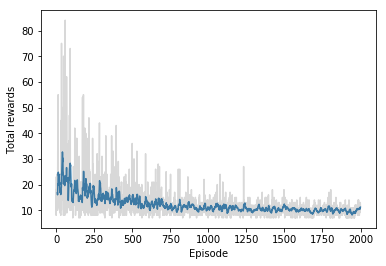

In [53]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Q losses')

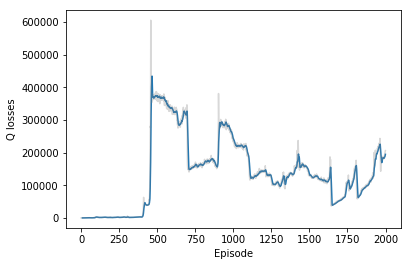

In [54]:
eps, arr = np.array(q_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Q losses')

Text(0,0.5,'G losses')

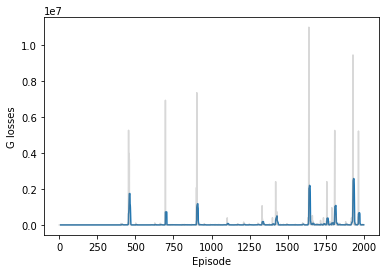

In [55]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

In [ ]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [43]:
test_episodes = 1
test_max_steps = 20000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

# # # Create the env after closing it.
# # env = gym.make('CartPole-v0')
# # env = gym.make('Acrobot-v1')
# env.reset()

with tf.Session() as sess:
    
    # Restore/load the trained model 
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # iterations
    for ep in range(test_episodes):
        
        # number of env/rob steps
        t = 0
        while t < test_max_steps:
            
            # Rendering the env graphics
            env.render()
            
            # Get action from the model
            feed_dict = {model.prev_actions: np.array([prev_action]), 
                         model.states: state.reshape((1, *state.shape))}
            actions_logits = sess.run(model.actions_logits, feed_dict)
            action = np.argmax(actions_logits)
            
            # Take action, get new state and reward
            next_state, _, done, _ = env.step(action)
            
            # The task is done or not;
            if done:
                t = test_max_steps
                env.reset()
                
                # Take one random step to get the pole and cart moving
                prev_action = env.action_space.sample()
                state, reward, done, _ = env.step(prev_action)
            else:
                state = next_state
                t += 1

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


In [45]:
# Closing the env
# WARNING: If you close, you can NOT restart again!!!!!!
env.close()

## Extending this to Deep Convolutional QAN

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.